<a href="https://colab.research.google.com/github/pakkei1212/SMU_AML_PROJ/blob/main/Hotel_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.4 MB/s eta 0:00:00


In [22]:
from re import VERBOSE
import optuna
from sklearn.metrics import (
    f1_score, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import joblib
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import tqdm
import shap

RANDOM_STATE = 2025
VERBOSE = 2

Optimizing Trials:   0%|          | 0/3 [36:04<?, ?it/s]


In [2]:
#@title connect google drive

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU_MITB_AML_PRO/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SMU_MITB_AML_PRO


In [3]:
raw_hotel_data = pd.read_csv('hotel_data_cleaned.csv')

In [4]:
hotel_data = raw_hotel_data.copy()

In [5]:
hotel_data.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,country_binned_IRL,country_binned_ITA,country_binned_NLD,country_binned_Other,country_binned_PRT,agent_binned_9.0,agent_binned_14.0,agent_binned_240.0,agent_binned_Not Specified,agent_binned_Other
0,0.0,0.464043,0.0,0.0,0.0,0.00,0.036364,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,0.0,1.000000,0.0,0.0,0.0,0.00,0.036364,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2,0.0,0.009498,0.0,0.0,0.0,0.02,0.018182,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,0.017639,0.0,0.0,0.0,0.02,0.018182,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,0.018996,0.0,0.0,0.0,0.04,0.036364,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
X = hotel_data.drop('is_canceled', axis=1)
y = hotel_data['is_canceled']

In [25]:
class ClassifierModelWithOptuna:
    def __init__(self, X, y, model_class, param_space_func, n_trials=20, n_splits=5):
        """
        model_class: e.g., LogisticRegression
        param_space_func: callable(trial) → dict of model kwargs
        """
        self.X = X
        self.y = y
        self.model_class = model_class
        self.param_space_func = param_space_func
        self.n_trials = n_trials
        self.n_splits = n_splits

        self.best_model = None
        self.best_params = None
        self.study = None

    def objective(self, trial):
        params = self.param_space_func(trial)
        model = self.model_class(**params)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=RANDOM_STATE)
        scores = cross_val_score(model, self.X, self.y, cv=skf, scoring='roc_auc', error_score='raise')
        return scores.mean()

    def optimize(self):

        pbar = tqdm.tqdm(total=self.n_trials, desc="Optimizing Trials")

        def tqdm_callback(study, trial):
            pbar.update(1)

        self.study = optuna.create_study(direction='maximize')
        self.study.optimize(self.objective, n_trials=self.n_trials, callbacks=[tqdm_callback])

        pbar.close()

        self.best_params = self.param_space_func(self.study.best_trial)
        self.best_model = self.model_class(**self.best_params)
        self.best_model.fit(self.X, self.y)

        print("Best Parameters:", self.best_params)
        print("Best AUC Score:", self.study.best_value)

    def predict(self, X_test, y_test=None):
        y_pred = self.best_model.predict(X_test)
        y_prob = self.best_model.predict_proba(X_test)[:, 1] if hasattr(self.best_model, 'predict_proba') else None

        if y_test is not None:
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred, digits=4))

            if y_prob is not None:
                auc = roc_auc_score(y_test, y_prob)
                print(f"AUC Score: {auc:.4f}")

                # Plot ROC curve
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                plt.figure()
                plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
                plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.title("ROC Curve")
                plt.legend()
                plt.grid(True)
                plt.show()

        return y_pred

    def get_top_k_features(self, X_val, y_val=None, method='permutation', k=10):
      if self.best_model is None:
          print("No trained model found. Please run optimize() first.")
          return None

      # Permutation is for linear model
      if method == 'permutation':
          result = permutation_importance(self.best_model, X_val, y_val, scoring='f1', n_repeats=5, random_state=42)
          importances = result.importances_mean
          feature_names = X_val.columns if hasattr(X_val, 'columns') else [f'feature_{i}' for i in range(X_val.shape[1])]

          perm_df = pd.DataFrame({
              'feature': feature_names,
              'importance': importances
          }).sort_values('importance', ascending=False)

          print(f"\nTop {k} features by Permutation Importance:")
          return perm_df.head(k)

      # Shap is for tree models
      elif method == 'shap':
          try:
              explainer = shap.Explainer(self.best_model, X_val)
              shap_values = explainer(X_val)
          except Exception as e:
              print(f"Falling back to KernelExplainer due to: {e}")
              background = shap.utils.sample(X_val, 100)
              explainer = shap.KernelExplainer(self.best_model.predict_proba, background)
              shap_values = explainer.shap_values(X_val)

          # Handle shap_values for binary classification
          if isinstance(shap_values, list):  # binary classification case
              shap_vals = shap_values[1] if len(shap_values) > 1 else shap_values[0]
          else:
              shap_vals = shap_values.values

          abs_mean_shap = np.abs(shap_vals).mean(axis=0)
          feature_names = X_val.columns if hasattr(X_val, 'columns') else [f'feature_{i}' for i in range(X_val.shape[1])]

          shap_df = pd.DataFrame({
              'feature': feature_names,
              'importance': abs_mean_shap
          }).sort_values('importance', ascending=False)

          print(f"\nTop {k} features by SHAP Importance:")
          return shap_df.head(k)

      else:
          raise ValueError("Method must be either 'permutation' or 'shap'")

    def export_model(self, model_path='best_model.pkl', info_path='best_model_info.json'):
        if self.best_model is None:
            print("No best model to export.")
            return

        joblib.dump(self.best_model, model_path)
        info = {
            'best_params': self.best_params,
            'best_score': float(self.study.best_value)
        }
        with open(info_path, 'w') as f:
            json.dump(info, f, indent=2)

        print(f"Model saved to {model_path}")
        print(f"Info saved to {info_path}")

    def import_model(self, model_path='best_model.pkl', info_path='best_model_info.json'):
        self.best_model = joblib.load(model_path)
        with open(info_path, 'r') as f:
            info = json.load(f)
            self.best_params = info['best_params']

Optimizing Trials:   0%|          | 0/10 [00:00<?, ?it/s][I 2025-06-02 03:00:14,783] A new study created in memory with name: no-name-941b7195-d63b-41e1-81b9-081916b3584f
[I 2025-06-02 03:00:32,088] Trial 0 finished with value: 0.8596337241250632 and parameters: {'solver': 'lbfgs', 'C': 0.051189139928466236, 'class_weight': None}. Best is trial 0 with value: 0.8596337241250632.
Optimizing Trials: 100%|██████████| 10/10 [01:25<00:00,  8.51s/it]


Best Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.24334930030216295, 'class_weight': None, 'max_iter': 1000}
Best AUC Score: 0.8672854708251233

Classification Report:
              precision    recall  f1-score   support

         0.0     0.8466    0.9103    0.8773     12716
         1.0     0.7002    0.5595    0.6220      4760

    accuracy                         0.8148     17476
   macro avg     0.7734    0.7349    0.7497     17476
weighted avg     0.8068    0.8148    0.8078     17476

AUC Score: 0.8688


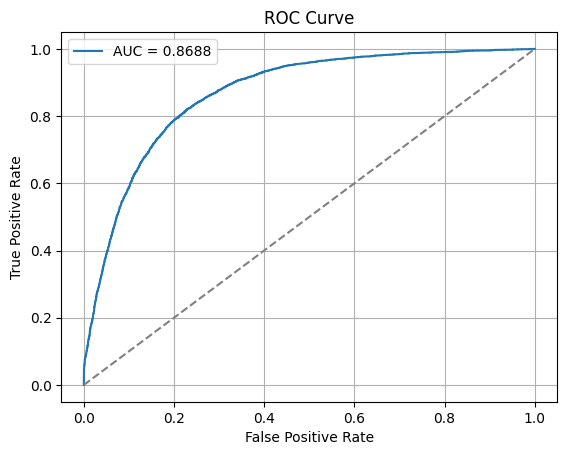

Model saved to best_model.pkl
Info saved to best_model_info.json


In [32]:
# Define parameter search space for LogisticRegression
def logistic_param_space(trial):
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
    penalty = "l2" if solver == "lbfgs" else trial.suggest_categorical("penalty", ["l1", "l2"])

    params = {
        "solver": solver,
        "penalty": penalty,
        "C": trial.suggest_float("C", 1e-3, 10.0, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "max_iter": 1000
    }

    return params

# Train
model = ClassifierModelWithOptuna(
    X=X, y=y,
    model_class=LogisticRegression,
    param_space_func=logistic_param_space,
    n_splits=5,
    n_trials=10
)
model.optimize()

# Evaluate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
model.best_model.fit(X_train, y_train)
model.predict(X_test, y_test)

# Export the model
model.export_model()

In [33]:
# Import the model
model.import_model()
print(model.best_params)

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.24334930030216295, 'class_weight': None, 'max_iter': 1000}


In [34]:
model.get_top_k_features(X_test, y_test, method='permutation', k=10)


Top 10 features by Permutation Importance:


,feature,importance
82,agent_binned_9.0,0.123149
16,lead_time_log,0.119705
81,country_binned_PRT,0.093743
84,agent_binned_240.0,0.075478
15,total_of_special_requests,0.064008
20,room_type_match,0.054583
14,required_car_parking_spaces,0.034569
1,arrival_date_year,0.023764
37,market_segment_Offline TA/TO,0.023087
67,customer_type_Transient,0.016107
